## Inference with the fitted outfit code

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import sys
import yaml
import pickle
import numpy as np
import pandas as pd
from skimage import io
from munch import munchify

import torch

sys.path.append(os.path.abspath('')+'/src')

from dataloaders.loaders.utils import make_dataloader

from models.draping_network_wrapper import Wrapper
from models.nstack import NeuralStack, PointNeuralTex
from models.pcd_converter import PCDConverter
from models.pcd_renderer import Renderer

from outfit_code.infer import infer_pid

### Dataloader and models setup

In [2]:
# config setup
config_path = 'configs/outfit_code/psp.yaml'
pid = 'male-3-casual'

with open(config_path, 'r') as stream:
    config = yaml.safe_load(stream)
config = munchify(config)
config.device = 'cuda:0'

# dataloader setup
data_root = config.data_root
data_name = data_root.split('/')[-1]
rgb_dir = config.rgb_dir
segm_dir = config.segm_dir
smpl_dir = config.smpl_dir

if config.get('splits_dir'):
    datalists = [pd.read_csv(f'{data_root}/{config.splits_dir}/{pid}/fit1.csv')]
else:
    datalists = [[pid]]

dataloader = make_dataloader(data_name, data_root, rgb_dir, segm_dir, smpl_dir, datalists[0], 
                             smpl_model_path='data/smpl_models/SMPL_NEUTRAL.pkl',
                             train=False, batch_size=1)

# models setup
draping_network = Wrapper.get_net(config)
converter = PCDConverter(config.device)
ndesc_stack = NeuralStack(1, lambda: PointNeuralTex(config.ntex_dim, config.pcl_size)).to(config.device)
renderer = Renderer(height=config.image_size[0], width=config.image_size[1], 
                    pcd_features_dim=config.ntex_dim, visibility_thr=2e-3, device=config.device)

# image paths (for visualization) setup
image_paths_file = f'out/outfit_code/image_paths_{data_name}.pkl'
image_paths_dict = pickle.load(open(image_paths_file, 'rb'))
print('\n> Image paths dict:', image_paths_dict)

# outfit codes setup
outfit_codes_file = f'out/outfit_code/outfit_codes_{data_name}.pkl'
outfit_codes_dict = pickle.load(open(outfit_codes_file, 'rb'))
print('\n> Outfit codes dict:', outfit_codes_dict)


> Loading the draping network model from checkpoints/draping_network_90_epochs.pth...

> Image paths dict: {'male-1-casual': 'samples/psp/rgb/male-1-casual/000001.png', 'male-3-casual': 'samples/psp/rgb/male-3-casual/000001.png'}

> Outfit codes dict: {'male-1-casual': array([ 0.0809941 , -0.43872824,  0.20763539,  0.4111563 , -0.7133698 ,
       -0.07154377, -0.23637031, -0.2811662 ], dtype=float32), 'male-3-casual': array([-0.5855567 , -0.19764575,  0.06156886,  0.33132124,  0.36146787,
       -0.11059047, -0.5225461 ,  0.30553007], dtype=float32)}


### Inference

Current style: pid=male-3-casual, shape=torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


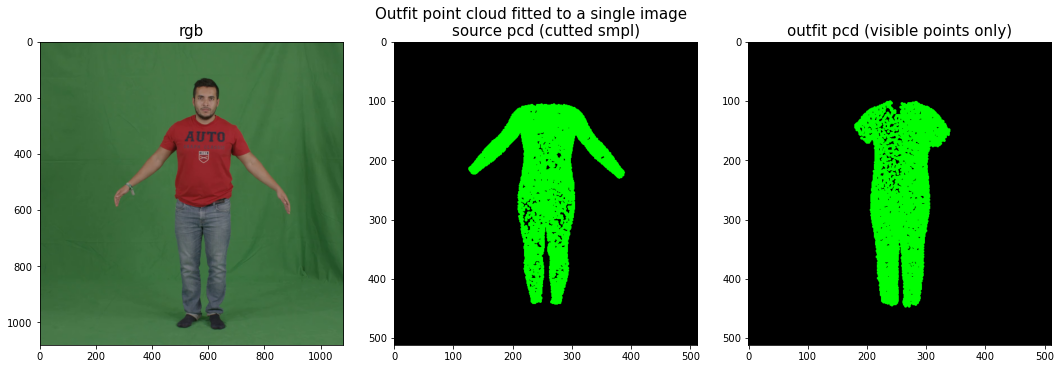

In [3]:
infer_pid(dataloader, outfit_codes_dict, image_paths_dict, 
          draping_network, converter, ndesc_stack, renderer, pid)